In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [119]:
#df = pd.read_csv('../elena/barros_2011_training.csv')
df = pd.read_csv('../data/training_final_latcorr.csv')

## Clean / Reverse Engineer Features
- Electricity generated (kWh)
- Drop redundant columns
- Drop non-lc columns

In [120]:
df['kWh'] = df['Area_km2'] / df['Area / Electricity']
df = df.drop(['Longitude', 'Latitude','CO2 (g/kWh)', 'CH4 (g/kWh)', 'Area / Electricity', 'Name', 'field_1',
              'temp_spring_avg', 'temp_summer_avg', 'temp_fall_avg', 'temp_winter_avg', 'temp_diff_summer_winter_lc',
              'NDVI_spring_avg', 'NDVI_summer_avg', 'NDVI_fall_avg', 'NDVI_winter_avg', 
              'npp_spring_avg' , 'npp_summer_avg' , 'npp_fall_avg' , 'npp_winter_avg'], axis=1)

In [121]:
df.columns

Index(['CO2 (mg C m¯² d¯¹)', 'CH4 (mg C m-2 d-1)', 'Area_km2', 'Age',
       'Volume_km3', 'Areakm2_div_Volkm3', 'org_c', 'temp_annual_avg',
       'temp_spring_avg_lc', 'temp_summer_avg_lc', 'temp_fall_avg_lc',
       'temp_winter_avg_lc', 'NDVI_annual_avg', 'NDVI_spring_avg_lc',
       'NDVI_summer_avg_lc', 'NDVI_fall_avg_lc', 'NDVI_winter_avg_lc',
       'npp_annual_avg', 'npp_spring_avg_lc', 'npp_summer_avg_lc',
       'npp_fall_avg_lc', 'npp_winter_avg_lc', 'erosion', 'precip', 'kWh'],
      dtype='object')

In [122]:
co2 = df.drop(['CH4 (mg C m-2 d-1)'], axis=1)
co2 = co2[co2['CO2 (mg C m¯² d¯¹)'].notna()]

## XGBoost

In [7]:
import xgboost

In [123]:
from sklearn.preprocessing import StandardScaler

data = co2.copy()
scaler = StandardScaler()
co2_scaled = pd.DataFrame(scaler.fit_transform(data),columns=co2.columns)

In [124]:
X = co2_scaled.drop('CO2 (mg C m¯² d¯¹)', axis=1)
Y = co2['CO2 (mg C m¯² d¯¹)']

In [125]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

In [126]:
from sklearn.impute import KNNImputer
model_impute = KNNImputer(n_neighbors=int(np.sqrt(x_train.shape[0])))
x_train_imputed = model_impute.fit_transform(x_train)

x_train_imputed = pd.DataFrame(columns=x_train.columns, data=x_train_imputed)

In [127]:
y_train_sq = y_train**2
y_val_sq = y_val**2
y_test_sq = y_test**2

In [128]:
xgb_reg_sq = xgboost.XGBRegressor(learning_rate=.8, n_estimators=100, max_depth=10)

xgb_reg_sq.fit(x_train_imputed, y_train_sq, 
             eval_set=[(x_val, y_val_sq)], 
             early_stopping_rounds=10)

print('train r2:', xgb_reg_sq.score(x_train_imputed, y_train_sq))
print('test  r2:', xgb_reg_sq.score(x_test, y_test_sq))

[0]	validation_0-rmse:1806555.75000
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1863436.75000
[2]	validation_0-rmse:1906339.12500
[3]	validation_0-rmse:1947690.75000
[4]	validation_0-rmse:1977339.12500
[5]	validation_0-rmse:1997145.50000
[6]	validation_0-rmse:2009658.12500
[7]	validation_0-rmse:2017364.37500
[8]	validation_0-rmse:2022083.12500
[9]	validation_0-rmse:2024933.37500
[10]	validation_0-rmse:2026656.62500
Stopping. Best iteration:
[0]	validation_0-rmse:1806555.75000

train r2: 0.6498107078214889
test  r2: 0.47176425504814906


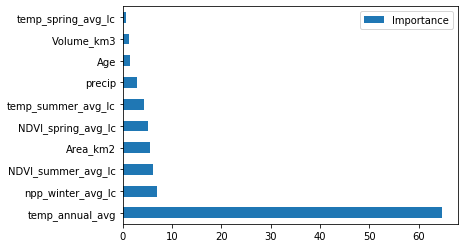

In [129]:
pd.DataFrame(index=x_train.columns, data=xgb_reg_sq.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')
